In [1]:
import pandas as pd
import numpy as np  

sales_df = pd.read_csv("Working_df/Actuals_all.csv")
features_df = pd.read_csv("Working_df/Competitors.csv")

d:\School\ITU\Coding\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\danii\AppData\Local\Temp\ipykernel_10360\2008953236.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_df = pd.read_csv("Working_df/Actuals_all.csv")


In [2]:
# Convert and align sales 'Date'
sales_df['Date'] = pd.to_datetime(sales_df['Date'])
sales_df['Week_Start'] = sales_df['Date'] - pd.to_timedelta(sales_df['Date'].dt.weekday, unit='D')

# Aggregate weekly sales (sum or mean depending on what you need)
weekly_sales = sales_df.groupby('Week_Start')['Sum of Invoiced Amount EUR'].sum().reset_index()
weekly_sales.rename(columns={'Week_Start': 'Date', 'Sum of Invoiced Amount EUR': 'Weekly_Sales'}, inplace=True)


In [3]:
# Make sure both are in datetime format
features_df['Date'] = pd.to_datetime(features_df['Date'])
weekly_sales['Date'] = pd.to_datetime(weekly_sales['Date'])

# Now try the merge again
merged_df = weekly_sales.merge(features_df, on='Date', how='left')



Residual correlation

In [4]:
residuals_df = pd.read_csv("Working_df/residuals.csv", header=None, names=["Date", 'Weekly_Sales'])
residuals_df['Date'] = pd.to_datetime(residuals_df['Date'])


In [5]:

merged_df = residuals_df.merge(features_df, on='Date', how='left')


In [6]:
merged_df = merged_df.drop(index=0)
merged_df_clean = merged_df.dropna()

In [7]:
# Count NaNs in each column
nan_counts = merged_df_clean.isna().sum().sort_values(ascending=False)

# Display all columns with at least one NaN
print(nan_counts[nan_counts > 0])


Series([], dtype: int64)


In [8]:
# Try different lags (e.g., 1 to 8 weeks)
for lag in range(1, 13):
    merged_df_clean[f'Sales_lag_{lag}'] = merged_df_clean['Weekly_Sales'].shift(-lag)  # sales n weeks *after* market signal


C:\Users\danii\AppData\Local\Temp\ipykernel_10360\2088276588.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_clean[f'Sales_lag_{lag}'] = merged_df_clean['Weekly_Sales'].shift(-lag)  # sales n weeks *after* market signal
C:\Users\danii\AppData\Local\Temp\ipykernel_10360\2088276588.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_clean[f'Sales_lag_{lag}'] = merged_df_clean['Weekly_Sales'].shift(-lag)  # sales n weeks *after* market signal
C:\Users\danii\AppData\Local\Temp\ipykernel_

In [9]:
correlation_results = {}

for lag in range(1, 13):
    lagged_col = f'Sales_lag_{lag}'
    temp_corr = merged_df_clean.dropna().corr()[lagged_col].drop(lagged_col)
    correlation_results[f'lag_{lag}'] = temp_corr
    print(f"Correlation with lag {lag}:\n{temp_corr}\n")
# Combine into DataFrame for easy view
correlation_df = pd.DataFrame(correlation_results)


Correlation with lag 1:
Date                   -0.010143
Weekly_Sales            0.020372
STMN.SW_pct_change      0.047001
STMN.SW_rolling_mean   -0.004575
STMN.SW_rolling_vol     0.030747
ALGN_pct_change        -0.029112
ALGN_rolling_mean       0.014897
ALGN_rolling_vol        0.009159
XRAY_pct_change        -0.006990
XRAY_rolling_mean       0.009100
XRAY_rolling_vol        0.014625
HSIC_pct_change         0.011554
HSIC_rolling_mean       0.036214
HSIC_rolling_vol        0.006464
^VIX_pct_change        -0.047744
^VIX_rolling_mean      -0.017375
^VIX_rolling_vol       -0.076597
Sales_lag_2             0.021848
Sales_lag_3             0.062181
Sales_lag_4             0.023807
Sales_lag_5            -0.098504
Sales_lag_6             0.039143
Sales_lag_7            -0.005431
Sales_lag_8             0.005939
Sales_lag_9             0.048133
Sales_lag_10            0.077311
Sales_lag_11           -0.019565
Sales_lag_12           -0.111813
Name: Sales_lag_1, dtype: float64

Correlation with 

Correlation with lag 8:
Date                    0.043903
Weekly_Sales            0.044643
STMN.SW_pct_change     -0.020334
STMN.SW_rolling_mean    0.013805
STMN.SW_rolling_vol    -0.061077
ALGN_pct_change        -0.043850
ALGN_rolling_mean       0.006615
ALGN_rolling_vol       -0.016122
XRAY_pct_change        -0.030338
XRAY_rolling_mean      -0.050122
XRAY_rolling_vol       -0.097472
HSIC_pct_change         0.038604
HSIC_rolling_mean       0.032309
HSIC_rolling_vol       -0.175449
^VIX_pct_change         0.012277
^VIX_rolling_mean       0.040957
^VIX_rolling_vol       -0.035881
Sales_lag_1             0.005939
Sales_lag_2             0.002463
Sales_lag_3             0.055677
Sales_lag_4            -0.081208
Sales_lag_5             0.042383
Sales_lag_6             0.082620
Sales_lag_7             0.048789
Sales_lag_9             0.072458
Sales_lag_10            0.107512
Sales_lag_11            0.085968
Sales_lag_12           -0.061239
Name: Sales_lag_8, dtype: float64

Correlation with 

In [10]:
import pandas as pd

def dict_to_dataframe(data_dict):
    """
    Converts a dictionary of lists or Series into a pandas DataFrame.
    Keys become column names.

    Parameters:
    - data_dict: dict with structure {column_name: list/Series}

    Returns:
    - pd.DataFrame with each key as a column
    """
    return pd.DataFrame({k: pd.Series(v) for k, v in data_dict.items()})


In [11]:
correlation_df = dict_to_dataframe(correlation_results)

In [12]:
print(correlation_df)

                         lag_1     lag_2     lag_3     lag_4     lag_5  \
ALGN_pct_change      -0.029112 -0.093143 -0.006041  0.055077 -0.064859   
ALGN_rolling_mean     0.014897  0.021708  0.024565  0.024508  0.022216   
ALGN_rolling_vol      0.009159  0.021917  0.044078  0.031392  0.033830   
Date                 -0.010143 -0.001190  0.010491  0.011207  0.020917   
HSIC_pct_change       0.011554  0.004728  0.024644  0.014547  0.001369   
HSIC_rolling_mean     0.036214  0.034511  0.033843  0.029116  0.027340   
HSIC_rolling_vol      0.006464  0.092821  0.083296  0.024290 -0.020567   
STMN.SW_pct_change    0.047001 -0.040762  0.004836  0.057968 -0.071814   
STMN.SW_rolling_mean -0.004575  0.000646  0.007735  0.008307  0.012629   
STMN.SW_rolling_vol   0.030747 -0.018894  0.025931 -0.032403 -0.016839   
Sales_lag_1                NaN  0.021848  0.062181  0.023807 -0.098504   
Sales_lag_10          0.077311  0.055305  0.031612  0.025626  0.061851   
Sales_lag_11         -0.019565  0.0890

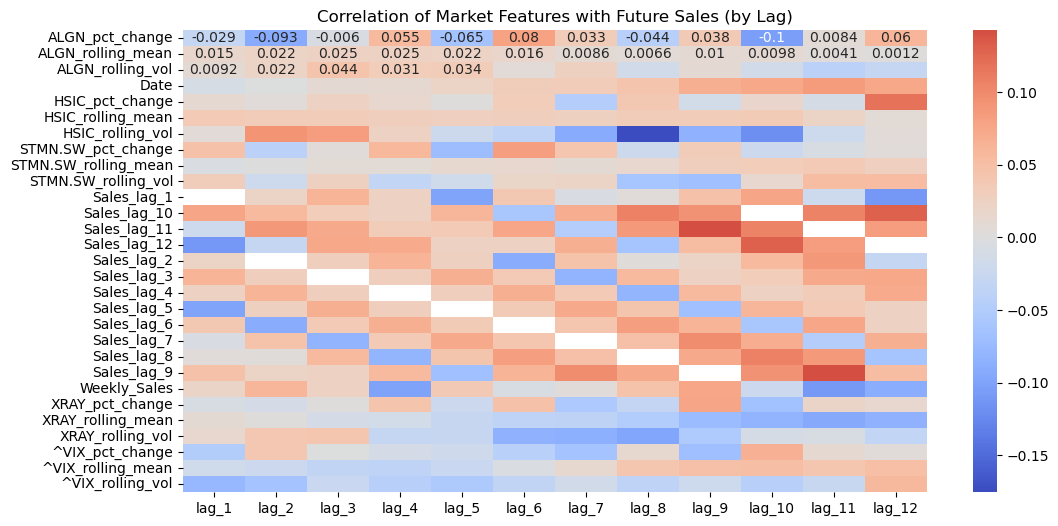

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Market Features with Future Sales (by Lag)')
plt.show()


In [14]:
def get_best_lag_correlations(correlation_df):
    """
    Finds the lag (column) with the strongest correlation (positive or negative)
    for each row in the correlation DataFrame.

    Parameters:
    - correlation_df: pd.DataFrame with features as rows and lags as columns

    Returns:
    - pd.DataFrame with: feature, best_lag, correlation
    """
    results = []

    for feature in correlation_df.index:
        row = correlation_df.loc[feature]
        row = row.dropna()

        if row.empty:
            continue

        best_lag = row.abs().idxmax()
        best_corr = row[best_lag]

        results.append({
            "feature": feature,
            "best_lag": best_lag,
            "correlation": best_corr
        })

    return pd.DataFrame(results).sort_values(by='correlation', ascending=False)


In [15]:
best_lags_df = get_best_lag_correlations(correlation_df)
print(best_lags_df)


                 feature best_lag  correlation
12          Sales_lag_11    lag_9     0.142710
21           Sales_lag_9   lag_11     0.142710
11          Sales_lag_10   lag_12     0.129166
13          Sales_lag_12   lag_10     0.129166
4        HSIC_pct_change   lag_12     0.117985
20           Sales_lag_8   lag_10     0.107512
19           Sales_lag_7    lag_9     0.097530
3                   Date   lag_11     0.084776
7     STMN.SW_pct_change    lag_6     0.081982
23       XRAY_pct_change    lag_9     0.077128
27     ^VIX_rolling_mean   lag_10     0.051506
2       ALGN_rolling_vol    lag_3     0.044078
8   STMN.SW_rolling_mean   lag_11     0.036839
5      HSIC_rolling_mean    lag_1     0.036214
1      ALGN_rolling_mean    lag_3     0.024565
9    STMN.SW_rolling_vol    lag_9    -0.068161
26       ^VIX_pct_change    lag_9    -0.069222
28      ^VIX_rolling_vol    lag_1    -0.076597
16           Sales_lag_4    lag_8    -0.081208
15           Sales_lag_3    lag_7    -0.082348
14           

In [16]:
def get_best_lag_correlations(correlation_df, threshold=0.3):
    """
    Finds the best lag (column) with strongest correlation (positive or negative)
    for each feature in the correlation DataFrame.

    Filters to only include those with |correlation| >= threshold.

    Parameters:
    - correlation_df: pd.DataFrame with features as rows and lags as columns
    - threshold: minimum absolute correlation to keep (default = 0.3)

    Returns:
    - pd.DataFrame with: feature, best_lag, correlation, abs_correlation
    """
    results = []

    for feature in correlation_df.index:
        row = correlation_df.loc[feature]
        row = row.dropna()

        if row.empty:
            continue

        best_lag = row.abs().idxmax()
        best_corr = row[best_lag]

        if abs(best_corr) >= threshold:
            results.append({
                "feature": feature,
                "best_lag": best_lag,
                "correlation": best_corr,
                "abs_correlation": abs(best_corr)
            })

    return pd.DataFrame(results).sort_values(by="abs_correlation", ascending=False)


In [17]:
# Show top relationships with correlation above 0.3 (positive or negative)
top_lagged_features = get_best_lag_correlations(correlation_df, threshold=0.3)
print(top_lagged_features)


KeyError: 'abs_correlation'

In [ ]:
def create_selected_lagged_features(features_df):
    """
    Creates a DataFrame with only the top selected lagged features.

    Selected features and lags:
    - STMN.SW_rolling_mean → lag_1
    - HSIC_rolling_mean → lag_3
    - STMN.SW_rolling_vol → lag_1
    - XRAY_rolling_mean → lag_11

    Parameters:
    - features_df: DataFrame with market features and 'Date' column

    Returns:
    - DataFrame with lagged features + Date
    """
    df = features_df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    lag_config = {
        'STMN.SW_rolling_mean': 1,
        'HSIC_rolling_mean': 3,
        'STMN.SW_rolling_vol': 1,
        'XRAY_rolling_mean': 11
    }

    lagged_features = {'Date': df['Date']}

    for feature, lag in lag_config.items():
        if feature in df.columns:
            lagged_col_name = f'{feature}_lag{lag}'
            lagged_features[lagged_col_name] = df[feature].shift(lag)
        else:
            print(f"⚠️ Warning: {feature} not found in DataFrame")

    return pd.DataFrame(lagged_features)


In [ ]:
selected_lagged_df = create_selected_lagged_features(features_df)
print(selected_lagged_df.head())


        Date  STMN.SW_rolling_mean_lag1  HSIC_rolling_mean_lag3  \
0 2017-01-02                        NaN                     NaN   
1 2017-01-09                     37.489                     NaN   
2 2017-01-16                     37.987                     NaN   
3 2017-01-23                     38.082                  60.220   
4 2017-01-30                     38.169                  61.038   

   STMN.SW_rolling_vol_lag1  XRAY_rolling_mean_lag11  
0                       NaN                      NaN  
1                  0.520056                      NaN  
2                  0.358833                      NaN  
3                  0.273466                      NaN  
4                  0.204440                      NaN  


In [ ]:
#save df as csv
selected_lagged_df.to_csv("Working_df/Selected_lagged_features.csv", index=False)

Clients stock

In [ ]:
import pandas as pd

# Read the Excel file, skipping the first 6 rows
df = pd.read_excel("202504 - Deployement numbers.xlsx", skiprows=6)

# Drop the 'Country' column (if it exists)
df = df.drop(columns=['Country.Country Sub Region Name'], errors='ignore')

# Drop columns after 'SumYTD'
if 'SumYTD' in df.columns:
    end_col_idx = df.columns.get_loc('SumYTD') + 1
    df = df.iloc[:, :end_col_idx]

# Convert the date column
df['MonthDay_WithYear'] = pd.to_datetime(df['MonthDay_WithYear'], errors='coerce')

# Rename for consistency
df = df.rename(columns={'MonthDay_WithYear': 'deployment_date'})

# Preview result
print(df.head())


C:\Users\danii\AppData\Local\Temp\ipykernel_10636\887248107.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['MonthDay_WithYear'] = pd.to_datetime(df['MonthDay_WithYear'], errors='coerce')


  deployment_date  Customer.Customer Code  Item.Item Code  SumYTD
0      2016-12-01                  100091        22001201       1
1      2016-12-01                  100223        22001071       1
2      2016-12-01                  101112        22002050       1
3      2016-12-01                  100082        22001090       4
4      2016-12-01                  100082        22001131       1


In [ ]:
def simulate_running_customer_stock(sales_df, deployments_df):
    # Prepare copies and standardize keys
    sales_df = sales_df.copy()
    deployments_df = deployments_df.copy()

    for df in [sales_df, deployments_df]:
        df['Customer.Customer Code'] = df['Customer.Customer Code'].astype(str)
        df['item_code'] = df['item_code'].astype(str)

    deployments_df = deployments_df.dropna(subset=['deployment_date'])

    sales_df = sales_df.sort_values(by=['Customer.Customer Code', 'item_code', 'week_start']).reset_index(drop=True)
    deployments_df = deployments_df.sort_values(by=['Customer.Customer Code', 'item_code', 'deployment_date'])

    sales_df['customer_stock'] = float('nan')

    grouped_sales = sales_df.groupby(['Customer.Customer Code', 'item_code'])
    grouped_deploy = deployments_df.groupby(['Customer.Customer Code', 'item_code'])

    for key, group in grouped_sales:
        cust, item = key
        sales_rows = group.copy()
        deployments = grouped_deploy.get_group(key) if key in grouped_deploy.groups else pd.DataFrame(columns=['deployment_date', 'SumYTD'])

        stock = 0
        dep_index = 0
        deploy_queue = []

        for idx in sales_rows.index:
            sale_date = sales_df.at[idx, 'week_start']
            qty_sold = sales_df.at[idx, 'Sum of Invoiced Qty']

            # Queue deployments before this sale date
            while dep_index < len(deployments) and deployments.iloc[dep_index]['deployment_date'] <= sale_date:
                deploy_queue.append(deployments.iloc[dep_index]['SumYTD'])
                dep_index += 1

            # Apply all queued deployments now
            while deploy_queue:
                stock -= deploy_queue.pop(0)

            # Add the current sale
            stock += qty_sold

            # Save stock (clipped at 0)
            sales_df.at[idx, 'customer_stock'] = max(stock, 0)

    return sales_df


In [ ]:
import pandas as pd

# Load sales data
sales_df = pd.read_csv("Working_df/Actuals_all_enriched.csv", parse_dates=["week_start", "last_renewal_week"])

# Prepare deployment data (you already cleaned this into `df`)
deployments_df = df.copy()
deployments_df = deployments_df.iloc[:, :4]
deployments_df.columns = ['deployment_date', 'Customer.Customer Code', 'item_code', 'SumYTD']
deployments_df['deployment_date'] = pd.to_datetime(deployments_df['deployment_date'])

# Run stock simulation
sales_with_stock = simulate_running_customer_stock(sales_df, deployments_df)

# Preview result
print(sales_with_stock[['week_start', 'Customer.Customer Code', 'item_code', 'Sum of Invoiced Qty', 'customer_stock']].head())


C:\Users\danii\AppData\Local\Temp\ipykernel_10636\555899627.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_df = pd.read_csv("Working_df/Actuals_all_enriched.csv", parse_dates=["week_start", "last_renewal_week"])


  week_start Customer.Customer Code item_code  Sum of Invoiced Qty  \
0 2017-12-18                 100000  10009724                  1.0   
1 2021-04-05                 100000  80220916                  0.0   
2 2017-02-27                 100000  80240001                  1.0   
3 2017-03-06                 100000  80240001                  1.0   
4 2017-03-27                 100000  80240001                  2.0   

   customer_stock  
0             1.0  
1             0.0  
2             1.0  
3             2.0  
4             4.0  


In [ ]:
sales_with_stock.to_csv("Working_df/Actuals_with_stock.csv", index=False)

In [ ]:
def count_unique_customer_item_combinations(df, customer_col='Customer.Customer Code', item_col='item_code'):
    """
    Counts unique (customer, item) combinations in the dataset.

    Parameters:
    - df: pd.DataFrame
    - customer_col: str, column name for customer code
    - item_col: str, column name for item code

    Returns:
    - int: number of unique (customer, item) pairs
    """
    unique_combinations = df[[customer_col, item_col]].drop_duplicates()
    return len(unique_combinations)


In [ ]:
import pandas as pd
sales_df = pd.read_csv("Working_df/Actuals_all_enriched.csv")

d:\School\ITU\Coding\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\danii\AppData\Local\Temp\ipykernel_5516\240597306.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_df = pd.read_csv("Working_df/Actuals_all_enriched.csv")


In [ ]:
num_combinations = count_unique_customer_item_combinations(sales_df)
print(f"🧮 Unique (customer, item) combinations: {num_combinations}")


🧮 Unique (customer, item) combinations: 170766


In [ ]:
print(sales_df.head())

   year  week  week_start Customer.Customer Code item_code  \
0  2017    51  2017-12-18                 100000  10009724   
1  2021    14  2021-04-05                 100000  80220916   
2  2017     9  2017-02-27                 100000  80240001   
3  2017    10  2017-03-06                 100000  80240001   
4  2017    13  2017-03-27                 100000  80240001   

   Sum of Invoiced Amount EUR  Sum of Invoiced Qty      Country.Country Name  \
0                         0.0                  1.0  United States of America   
1                         0.0                  0.0  United States of America   
2                      1200.0                  1.0  United States of America   
3                      1200.0                  1.0  United States of America   
4                      2400.0                  2.0  United States of America   

      Item.Sales Model item_suffix  ...  is_subscription  is_new_sale  \
0  Production Sub Type         NaN  ...                0            0   
